In [1]:
import numpy as np
import sympy as sp
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import special


font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

## Kramers theory for moderate to high friction regime

In [2]:
def langevin_bbk_step(Q, P, M, gamma, beta, der_V, dt):
    
    Nreps = Q.shape[0]
    
    # bbk Coefficent
    L = 1 / (1 + 0.5 * gamma*dt)
    
    # Deterministic force
    F  =  - der_V(Q)
    
    # Random force 
    R  =  np.random.normal(0, 1, Nreps)
    
    # update p_{n+1/2}
    Phalf = ( 1 - 0.5 * gamma * dt ) * P + 0.5 * F * dt + 0.5 * np.sqrt( 2 / beta * dt * gamma * M ) * R
    
    # update q_{n+1}
    Q  =  Q + Phalf / M * dt
    
    # Recalculate deterministic force (but not the random force)
    F  =  - der_V(Q)
    
    # update p_{n+1}
    P = ( Phalf + 0.5 * F * dt + 0.5 * np.sqrt( 2 / beta * dt * gamma * M ) * R ) / ( 1 + 0.5 * gamma * dt ) 

    return Q, P

In [3]:
# System parameters
kB    = 0.008314463 # kJ mol-1 K
T     = 300         # K
mass  = 1           # amu
beta  = 1 / kB / T

print(kB * T)

2.4943389


In [4]:
# Initialize the variables x and y for symbolic calculation
x   =  sp.symbols('x')
Eb  =  10

# Define the potentials Va, Vb and V with sympy
V   =   Eb*(x**2 - 1)**2

xA = -1
xB =  0
xC =  1 

# Calculate derivative and second derivative with sympy
gradVx   =  V.diff(x)
grad2Vx2 =  gradVx.diff(x)

# To display sympy functions:
# display(gradVx)

# Convert potential and derivatives in numpy functions
V         =  sp.lambdify((x), V, modules=['numpy'])
gradVx    =  sp.lambdify((x), gradVx, modules=['numpy'])
grad2Vx2  =  sp.lambdify((x), grad2Vx2, modules=['numpy'])

# Approximation at xA and xB
omegaA = np.sqrt( np.abs(grad2Vx2(xA)) / mass )
kspringA     = omegaA ** 2 * mass



omegaB = np.sqrt( np.abs(grad2Vx2(xB)) / mass )
kspringB     = omegaB ** 2 * mass



def a(gamma):
    return ( gamma / ( 2 * omegaB ** 2 ) ) * ( np.sqrt( 1 + 4 * omegaB ** 2 / gamma ** 2 ) - 1 ) 
    
def u(x,p,gamma):
    return x - a(gamma) * p/mass

def xi( x, p, gamma ):
    arg = np.sqrt( mass * omegaB ** 2 / ( 2 * gamma * kB * T * a(gamma) ) )
    return 0.5 * special.erfc( arg * u(x,p,gamma) )

def xi_u( u, gamma ):
    arg = np.sqrt( mass * omegaB ** 2 / ( 2 * gamma * kB * T * a(gamma) ) )
    return 0.5 * special.erfc( arg * u )

def Peq_f(x,p):
    return np.exp( - 0.5 * beta * p ** 2 / mass - beta * V(x))


def Vlin(x):
    return V(xB) - 0.5 * mass * omegaB ** 2 * (x - xB) ** 2

def Peq_lin(x,p):
    return np.exp( - 0.5 * beta * p ** 2 / mass - beta * Vlin(x))

def Pss_f( x, p, gamma ):
    return Peq_f(x,p) * xi(x, p, gamma)

Eb = V(xB) - V(xA)
print(kB * T / Eb)

0.24943389


In [5]:
# Grid
xbins     = 50   
xmin      = - 2
xmax      = - xmin

xedges    = np.linspace(xmin, xmax, xbins)  # array with x edges
dx        = xedges[1] - xedges[0]
xcenters  = xedges[:-1] + (dx / 2)                # array with x centers
xbins     = xbins - 1

pbins     = 100  
pmin      = - 8
pmax      = - pmin

pedges    = np.linspace(pmin, pmax, pbins)  # array with x edges
dp        = pedges[1] - pedges[0]
pcenters  = pedges[:-1] + (dp / 2)                # array with x centers
pbins     = pbins - 1

xp        = np.meshgrid(xcenters, pcenters)
xpf       = np.array([xp[0].flatten('F'), xp[1].flatten('F')]).T

In [6]:
gamma2 = 1*omegaB
print(gamma2 / omegaB)

Nreps = 1
## Simulation

# Integrator timestep
dt  =  0.005 # ps
sdt =  np.sqrt(dt)

# Number of timesteps
Nsteps  =  50000

# Initial position
x0  =  xA + np.random.normal(0, 1, Nreps) * np.sqrt( 1 / beta / kspringA )
p0  =  np.random.normal(0, 1, Nreps) * np.sqrt( mass / beta )

# Arrays for x,y values
x2   =   np.zeros((Nsteps, Nreps))
p2   =   np.zeros((Nsteps, Nreps))

x2[0,:] = x0
p2[0,:] = p0

for k in tqdm(range(Nsteps-1)):
    x2[k+1,:], p2[k+1,:]   = langevin_bbk_step(x2[k,:], p2[k,:], mass, gamma2, beta, gradVx, dt)
    p2[k+1, x2[k+1,:]>=xC] = np.random.normal(0, 1, sum(x2[k+1,:]>=xC)) * np.sqrt( mass / beta )
    x2[k+1, x2[k+1,:]>=xC] = xA + np.random.normal(0, 1, sum(x2[k+1,:]>=xC)) * np.sqrt( 1 / beta / kspringA )

1.0


100%|█████████████████████████████████████████████████████████████████████████| 49999/49999 [00:03<00:00, 13339.95it/s]


In [42]:
p2.shape

(50000, 10)

In [7]:
# Boltzmann distribution
Peq = Peq_f(xp[0], xp[1]) 
Peq = Peq / np.sum( Peq * dx * dp )

# Calculate distributions    
Pss2 = np.histogram2d(x2.flatten(), p2.flatten(), bins=(xedges, pedges))[0].T
Pss2 = Pss2 / np.sum( Pss2 * dx * dp )

# Perturbing distribuitons
Xiss2 = Pss2 / Peq

Pss2_ex = Pss_f(xp[0], xp[1], gamma2) 

Xiss2_ex = xi(xp[0], xp[1], gamma2)

# Flux
f    = pcenters * Pss_f(0, pcenters, gamma2)
ff  = np.zeros((pbins, xbins)) 
ff[:,24] = f*dp

Text(0, 0.5, 'p')

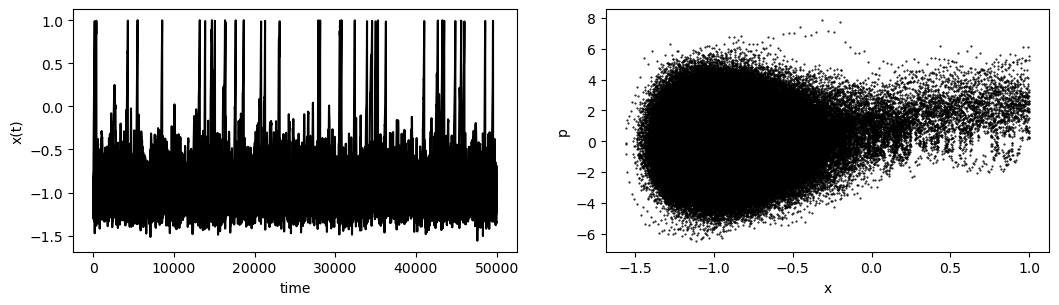

In [44]:
fig, ax = plt.subplots(1, 2,figsize=(32*in2cm, 8*in2cm), facecolor='white')  


ax[0].plot(x2,'k-')

ax[1].plot(x2, p2, 'k.', markersize = 1)

ax[0].set_xlabel('time')
ax[1].set_xlabel('x')

ax[0].set_ylabel('x(t)')
ax[1].set_ylabel('p')



In [47]:
gamma2 = 1*omegaB
print(gamma2 / omegaB)

Nreps = 100
## Simulation

# Integrator timestep
dt  =  0.005 # ps
sdt =  np.sqrt(dt)

# Number of timesteps
Nsteps  =  50000

# Initial position
x0  =  xA + np.random.normal(0, 1, Nreps) * np.sqrt( 1 / beta / kspringA )
p0  =  np.random.normal(0, 1, Nreps) * np.sqrt( mass / beta )

# Arrays for x,y values
x2   =   np.zeros((Nsteps, Nreps))
p2   =   np.zeros((Nsteps, Nreps))

x2[0,:] = x0
p2[0,:] = p0

for k in tqdm(range(Nsteps-1)):
    x2[k+1,:], p2[k+1,:]   = langevin_bbk_step(x2[k,:], p2[k,:], mass, gamma2, beta, gradVx, dt)
    p2[k+1, x2[k+1,:]>=xC] = np.random.normal(0, 1, sum(x2[k+1,:]>=xC)) * np.sqrt( mass / beta )
    x2[k+1, x2[k+1,:]>=xC] = xA + np.random.normal(0, 1, sum(x2[k+1,:]>=xC)) * np.sqrt( 1 / beta / kspringA )

1.0


100%|█████████████████████████████████████████████████████████████████████████| 49999/49999 [00:04<00:00, 10862.95it/s]


In [48]:
# Boltzmann distribution
Peq = Peq_f(xp[0], xp[1]) 
Peq = Peq / np.sum( Peq * dx * dp )

# Calculate distributions    
Pss2 = np.histogram2d(x2.flatten(), p2.flatten(), bins=(xedges, pedges))[0].T
Pss2 = Pss2 / np.sum( Pss2 * dx * dp )

# Perturbing distribuitons
Xiss2 = Pss2 / Peq

Pss2_ex = Pss_f(xp[0], xp[1], gamma2) 

Xiss2_ex = xi(xp[0], xp[1], gamma2)

# Flux
f    = pcenters * Pss_f(0, pcenters, gamma2)
ff  = np.zeros((pbins, xbins)) 
ff[:,24] = f*dp

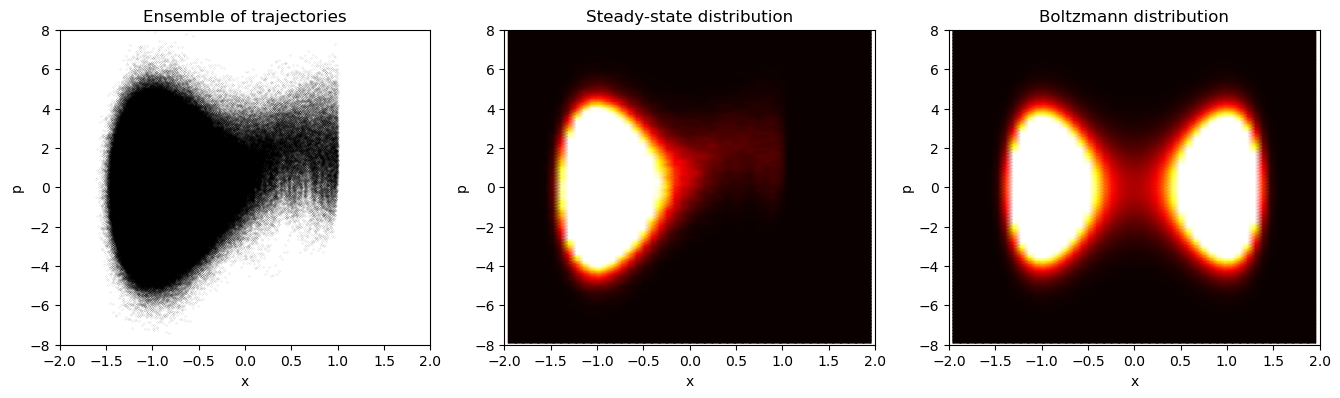

In [54]:
fig, ax = plt.subplots(1, 3,figsize=(32*in2cm, 8*in2cm), facecolor='white')  


ax[0].plot(x2,p2, 'k.', markersize=0.1);
pos = ax[1].pcolormesh(xp[0], xp[1], Pss2, shading='gouraud', vmax = 0.02, cmap = cm.hot)
pos = ax[2].pcolormesh(xp[0], xp[1], Peq, shading='gouraud',  vmax = 0.02, cmap = cm.hot)


ax[0].set_xlim(xmin,xmax)
ax[1].set_xlim(xmin,xmax)
ax[2].set_xlim(xmin,xmax)
ax[0].set_ylim(pmin,pmax)
ax[1].set_ylim(pmin,pmax)
ax[2].set_ylim(pmin,pmax)

ax[0].set_xlabel('x')
ax[0].set_ylabel('p')
ax[1].set_xlabel('x')
ax[1].set_ylabel('p')
ax[2].set_xlabel('x')
ax[2].set_ylabel('p')

ax[0].set_title('Ensemble of trajectories')
ax[1].set_title('Steady-state distribution')
ax[2].set_title('Boltzmann distribution')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.4);

fig.savefig('distributions.png', format='png', dpi=300, bbox_inches='tight')